In [1]:
import pymongo
import pandas as pd
#from pandas import Series
import numpy as np
np.set_printoptions(threshold='nan')
from numpy.linalg import inv
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
#from collections import Counter
from bson.objectid import ObjectId
import json
import pprint
from pydub import AudioSegment
import urllib
import fnmatch
import os
import requests
import ffmpy
import subprocess
import librosa
import librosa.display
import time

In [2]:
client = pymongo.MongoClient('localhost',27017)
#client = pymongo.MongoClient('localhost',32768)
db = client.get_database('b=bandhub')

In [3]:
songCol = db.get_collection('songsStream')
vidCol = db.get_collection('mergedVideos')
trackCol = db.get_collection('tracksStream')
postCol = db.get_collection('posts')
[songCol.count(), vidCol.count(), trackCol.count(), postCol.count()]

[425706, 198169, 915582, 494867]

In [4]:
def get_published_tracks(num_track):
""" This generator function returns all post documents with "num_track" public, published tracks, where num_track > 3.
----------
Arguments:
    num_track: Number of public, published tracks per mix

Returns:
    docs: All documents from the post collection that satisfy the aforementioned condition
"""
    
    pub_tracks = postCol.find({'songAccess':{'$exists': True}}, {'participantsInfo':1 ,'songAccess':1, 'objectId':1})
    for docs in pub_tracks:
        if(docs['songAccess'] == 1):
            if(len(docs['participantsInfo']['publishedTracks']) == num_track):
                yield docs

In [5]:
def get_processed_audio_ids(num_track):
""" This function computes a list of the post IDs & master song IDs of those mixes generated by the
get_published_tracks function that contain multiple mixing coefficients associated with the same mix.
----------
Arguments:
    num_track: Number of public, published tracks per mix

Returns:
    pub_songs: A list of lists containing relevant post & track IDs
"""
    
    pub_docs = [x for x in get_published_tracks(num_track)]
    count_mixes = len(pub_docs)
    print("Number of mixes with " + str(num_track) + " public, published tracks: " + str(count_mixes))
    missing_song_id = []
    missing_pubtrack = []
    index_required = []
    pub_songs = []
    for j in range(count_mixes):
        pub_tracks = []
        remix_test = pub_docs[j]['_id']
        song_id = pub_docs[j]['objectId']
        
        song_look_up = songCol.find({'masterSongId' : song_id})
        
        for i in range(num_track):
            pub_tracks.append(pub_docs[j]['participantsInfo']['publishedTracks'][i]['_id'])
                                
        if song_look_up is -1:
            missing_song_id.append(song_id)
            pprint.pprint('Error: SongID not found in Song Collection!')
        else:
            for song_docs in song_look_up:
                for i in range(len(pub_tracks)):
                    if(str(pub_tracks[i]) not in song_docs['settings']):
                        missing_pubtrack.append(pub_tracks[i])   
                        break
                    else:
                        if ('volume' in song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0] and 'volume' in song_docs['settings'][str(pub_tracks[i])]):
                            if (round(song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2) != round(song_docs['settings'][str(pub_tracks[i])]['volume'],2)):
                                index_required.append(j)
                                pub_songs.append([remix_test,song_id])
                                break
                            else:
                                continue
                        else:
                            #print('Mixing coefficient missing')
                            break

    return pub_songs

In [6]:
def get_filename(file):
""" This function strips the filename along with the file extension from the file URL.
----------
Arguments:
    file: file URL

Returns:
    filepath: file path
"""
    
    filePath = file.split('/')
    return filePath[- 1]

In [7]:
def get_mixing_coeff(num_track, song_id, post_id):
""" This function gathers all mixing coefficients necessary to remix a song using its constituent
published tracks.
----------
Arguments:
    num_track: Number of public, published tracks per mix
    song_id: Song ID
    post_id: Post ID

Returns:
    pub_t_vol: Published track volumes from the settings field in the song collection
    pub_t_vol_ch: Published track volumes from the audioChannels field within settings in the song collection
    ogg_paths: Processed (if available) or unprocessed file URLs of each published track
    start_times: Start times of each published track
"""
    
    pub_t_vol = []
    pub_t_vol_ch = []
    ogg_paths = []
    start_times = []
    track_filenames = []
    pub_tracks = []

    song_doc = songCol.find({'masterSongId' : song_id})
    post_doc = postCol.find({'_id' : post_id})
    
    for docs in post_doc:
        for i in range(num_track):
            pub_tracks.append(docs['participantsInfo']['publishedTracks'][i]['_id'])
    
    for docs in song_doc:    
        for i in range(len(pub_tracks)):
            if(str(pub_tracks[i]) in docs['settings']):
                pub_t_vol.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
                if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0]):
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2))
                else:
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
            
                gettrack = trackCol.find({'_id' : pub_tracks[i]})
                for tdocs in gettrack:
                    start_times.append(tdocs['startTimeValue'])
                    if('effectsAudioUrl' in docs['settings'][str(pub_tracks[i])]):
                        ogg_paths.append(docs['settings'][str(pub_tracks[i])]['effectsAudioUrl'])
                    else:
                        ogg_paths.append(tdocs['audioChannels'][0]['fileUrl'])
            else:
                print('Missing published track!')
        
    return pub_t_vol, pub_t_vol_ch, ogg_paths, start_times

In [8]:
def set_path():
""" This function sets the default download path to a subfolder within the user's scratch folder.
"""

    path = '/scratch/rrs432/tracks'
    os.chdir(path)

In [9]:
def download_track(ogg_path):
""" This function downloads the track using its filepath to the default download folder.
----------
Arguments:
    ogg_path: file path
"""    
    set_path()

    r = requests.get(ogg_path)
    filename = get_filename(ogg_path)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

In [10]:
def clear_downloads():
""" This function clears all previously downloaded songs/tracks in default download folder.
"""
    ! rm -rf *.ogg *.wav

Set all track lengths to that of the longest track

In [11]:
def match_track_lengths(num_track,track_filenames):
""" This function matches the track durations by zero padding the shorter tracks as well as converts all
mono tracks to stereo.
----------
Arguments:
    num_track: Number of public, published tracks per mix
    track_filenames: Filenames of tracks
    
Returns:
    ogg_tracks: Length-matched, downloaded, stereo tracks
    mixsr: Sampling rate of the tracks (Hz) 
"""
    
    ogg_tracks = []
    track_lens = []
    sam_rate = []
    for i in range(num_track):
        track, fs = sf.read('/scratch/rrs432/tracks/'+track_filenames[i])
        sam_rate.append(fs)
        track_lens.append(track.shape[0])
        #Convert mono to stereo
        if track.ndim is not 2:
            track = np.stack((track, track), axis = 1)
        ogg_tracks.append(track)

    if (min(sam_rate) == max(sam_rate)):
        mixsr = sam_rate[0] 
    else:
        pprint.pprint('Warning: Sample rates unequal')
    pprint.pprint(mixsr)
    
    master_track_len = max(track_lens)
    
    for i in range(num_track):
        diff = np.zeros(((master_track_len - track_lens[i]),2))
        ogg_tracks[i] = np.vstack((ogg_tracks[i], diff))
        pprint.pprint(np.shape(ogg_tracks[i]))
    
    return ogg_tracks, mixsr

In [12]:
def match_mix_lengths(mix1,mix2):
""" This function matches the mix durations by zero padding the shorter mix.
----------
Arguments:
    mix1: mix1
    mix2: mix2
    
Returns:
    mix1: Length-matched mix1
    mix2: Length-matched mix2 
"""
    if len(mix1) > len(mix2):
        diff_len = np.zeros(((len(mix1)-len(mix2)),2))
        mix2 = np.vstack((mix2, diff_len))
    else:
        diff_len = np.zeros(((len(mix2)-len(mix1)),2))
        mix1 = np.vstack((mix1, diff_len))
    return mix1, mix2

In [13]:
def compute_estimated_mix(num_track, vol, tracks, fs):
""" This function computes the estimated mix using relevant mixing coefficients.
----------
Arguments:
    num_track: Number of public, published tracks per mix
    vol: Track volume
    tracks: Track files
    fs: Sampling rate (Hz)

Returns:
    mix_ogg: Estimated mix file
"""    
    mix_ogg = 0
    for i in range(num_track):
        mix_ogg += (vol[i]*np.array(tracks[i]))
    return mix_ogg

In [14]:
def compute_offset_and_shift(estimated_mix, bandhub_mix):
""" This function corrects the offset introduced into the bandhub mix by the audio stripping process.
----------
Arguments:
    estimated_mix: This is the remix computed using the provided mixing coefficients.
    bandhub_mix: This is the mix provided to us by Bandhub. 
    
Returns:
    estimated_mix_spec: The estimated mix as a floating point time series.
    bandhub_mix_spec: The bandhub mix as a floating point time series.
"""    
    flag = 0
    if(len(estimated_mix) < len(bandhub_mix)):
        flag = -1
    estimated_mix, bandhub_mix = match_mix_lengths(estimated_mix, bandhub_mix)
    correlation = np.correlate(bandhub_mix[:mixsr,1], estimated_mix[:mixsr,1], 'full')
    #plt.plot(correlation)
    
    offset = np.argmax(correlation, axis=None)
    offset = (2*mixsr - 1)/2 - offset
    if offset is not 0:
        if flag is -1:
            estimated_mix = np.roll(estimated_mix, -offset)
        else:
            bandhub_mix = np.roll(bandhub_mix, -offset)

    sf.write('estimix.wav', estimated_mix, mixsr)
    sf.write('bandmix.wav', bandhub_mix, mixsr)
    
    estimated_mix_spec, sr = librosa.load('estimix.wav', sr=mixsr)
    bandhub_mix_spec, sr = librosa.load('bandmix.wav', sr=mixsr)
    
    print(np.shape(bandhub_mix_spec))
    print(np.shape(estimated_mix_spec))
    
    return estimated_mix_spec,bandhub_mix_spec

In [15]:
def plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec): 
""" This function plots difference spectograms between bandhub's mix and the estimated mix.
----------
Arguments:
    estimated_mix_spec: The estimated mix as a floating point time series.
    bandhub_mix_spec: The bandhub mix as a floating point time series. 
    
Returns:
    rmse: The root mean square error between the estimated and bandhub mixes.
"""  
    bandhub_mix_data = librosa.amplitude_to_db(librosa.stft(bandhub_mix_spec), ref=np.max)
    estimated_mix_data = librosa.amplitude_to_db(librosa.stft(estimated_mix_spec), ref=np.max)
    diff_mix_data = abs(np.subtract(bandhub_mix_data,estimated_mix_data))
    rmse = round(np.mean((diff_mix_data)**2),2)
    
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(diff_mix_data, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Diff Spectrogram')
    
    return rmse

Main script

In [18]:
set_path()
clear_downloads()

num_track = 7

proc_id = get_processed_audio_ids(num_track)

pprint.pprint(proc_id)

Number of mixes with 7 public, published tracks: 2661
[[ObjectId('546f0ca44e5d9e60267e6412'), ObjectId('526aa599819247db37000047')],
 [ObjectId('546fa9894e5d9e60267e8376'), ObjectId('525816846ed500ac73000038')]]


In [19]:
track_id = proc_id[1][0]
song_id = proc_id[1][1]
print(track_id)
print(song_id)

546fa9894e5d9e60267e8376
525816846ed500ac73000038


In [20]:
track_filenames = []

track_id = proc_id[1][0]
song_id = proc_id[1][1]

volume_settings, volume_channels, ogg_paths, start_times = get_mixing_coeff(num_track, song_id, track_id)

print(volume_settings)
print(volume_channels)
print('============')

for i in range(num_track):
    download_track(ogg_paths[i])
    track_filenames.append(get_filename(ogg_paths[i]))
    
pointer = vidCol.find({'songId': song_id})
for songdocs in pointer:
    bandhub_mix = songdocs['oggMergedVideoUrl']

download_track(bandhub_mix)

print('Downloads complete')
print('============')
!ls
print('============')

[0.34, 0.65, 0.77, 0.78, 0.19, 0.37, 1.0]
[0.34, 0.39, 0.77, 0.78, 0.19, 0.37, 1.0]
Downloads complete
04cdfb6a-fc31-47e0-b7ae-63c8cd4d8619.ogg
10e50bf2-dc3d-4acd-ac02-1d05125e32f8.ogg
29ca9ca4-2073-4d2b-a960-3760d2bd704c-0-0.ogg
2df8d117-f4cb-4d84-8fd1-b05cecfb7fe6.ogg
387f19ee-cfa8-468c-a3f3-940ff8f43f58.ogg
762a7c3c-6322-43e4-8d0d-22a62f64db70.ogg
7e676526-f8c6-41fe-8030-564fb041cab5.ogg
f-5a479991-a302-45ec-879c-efd97490aa72.ogg


In [21]:
ogg_tracks, mixsr = match_track_lengths(num_track,track_filenames)

for premix in os.listdir('.'):
    if fnmatch.fnmatch(premix, 'f-*'):
        rename_cmd = ['mv', premix, 'premix.ogg']
        s = subprocess.call(rename_cmd)
        if s is 0:
            print('success')
            
convert_cmd = ['ffmpeg', '-i', 'premix.ogg', '-vsync', '1', '-async', '1', '-vn', 'premix.wav']
subprocess.call(convert_cmd)

mix_ogg = compute_estimated_mix(num_track, volume_settings, ogg_tracks, mixsr)
sf.write('mixed.wav', mix_ogg / np.max(np.abs(mix_ogg)), mixsr)

mix_ogg_ch = compute_estimated_mix(num_track, volume_channels, ogg_tracks, mixsr)
sf.write('mixed_ch.wav', mix_ogg_ch / np.max(np.abs(mix_ogg_ch)), mixsr)

44100
(26689600, 2)
(26689600, 2)
(26689600, 2)
(26689600, 2)
(26689600, 2)
(26689600, 2)
(26689600, 2)
success


In [22]:
!ls

04cdfb6a-fc31-47e0-b7ae-63c8cd4d8619.ogg
10e50bf2-dc3d-4acd-ac02-1d05125e32f8.ogg
29ca9ca4-2073-4d2b-a960-3760d2bd704c-0-0.ogg
2df8d117-f4cb-4d84-8fd1-b05cecfb7fe6.ogg
387f19ee-cfa8-468c-a3f3-940ff8f43f58.ogg
762a7c3c-6322-43e4-8d0d-22a62f64db70.ogg
7e676526-f8c6-41fe-8030-564fb041cab5.ogg
mixed_ch.wav
mixed.wav
premix.ogg
premix.wav


(26689600,)
(26689600,)
(26689600,)
(26689600,)


/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


RMSE for estimated mix using volume from settings: 46.86
RMSE for estimated mix using volume from channels: 46.92


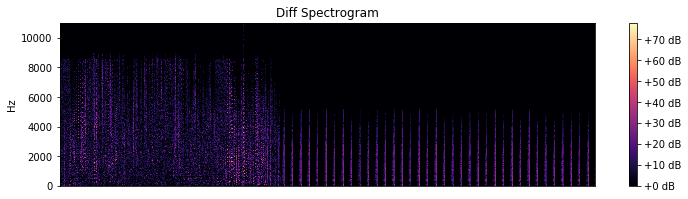

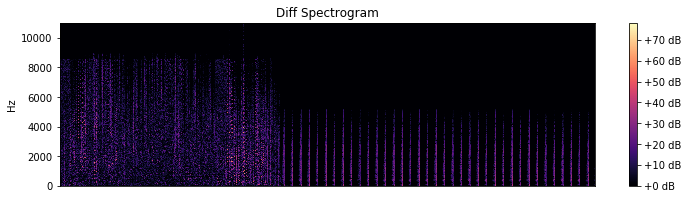

In [23]:
estimated_mix_ch, sr = sf.read('mixed_ch.wav')
estimated_mix, sr = sf.read('mixed.wav')
bandhub_mix, sr = sf.read('premix.wav')

estimated_mix_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix, bandhub_mix)
estimated_mix_ch_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix_ch, bandhub_mix)

root_mean_sq_error = plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from settings: '+str(root_mean_sq_error))
root_mean_sq_error = plot_diff_spectrogram(estimated_mix_ch_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from channels: '+str(root_mean_sq_error))